In [1]:
import os
import cv2
import numpy as np
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4)

        up1 = self.up1(bn)
        up1 = torch.cat([up1, d4], dim=1)
        up1 = self.conv1(up1)

        up2 = self.up2(up1)
        up2 = torch.cat([up2, d3], dim=1)
        up2 = self.conv2(up2)

        up3 = self.up3(up2)
        up3 = torch.cat([up3, d2], dim=1)
        up3 = self.conv3(up3)

        up4 = self.up4(up3)
        up4 = torch.cat([up4, d1], dim=1)
        up4 = self.conv4(up4)

        return torch.sigmoid(self.final(up4))


In [7]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=256):
        self.image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
        self.mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))
        
        self.img_size = img_size

        self.img_transform = T.Compose([
            T.ToTensor(),
            T.Resize((img_size, img_size)),
        ])

        self.mask_transform = T.Compose([
            T.ToTensor(),
            T.Resize((img_size, img_size)),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(self.mask_paths[idx], 0)
        mask = (mask > 128).astype("float32")  # binary

        # Apply transforms
        img = self.img_transform(img)
        mask = self.mask_transform(mask)

        return img, mask


In [8]:
train_dataset = CrackDataset(r"c:\Users\arunk\Downloads\crackforest\Images", r"c:\Users\arunk\Downloads\crackforest\Masks")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [10]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.5204
Epoch 2/20, Loss: 0.3615
Epoch 3/20, Loss: 0.3115
Epoch 4/20, Loss: 0.2851
Epoch 5/20, Loss: 0.2660
Epoch 6/20, Loss: 0.2466
Epoch 7/20, Loss: 0.2344
Epoch 8/20, Loss: 0.2214
Epoch 9/20, Loss: 0.2096
Epoch 10/20, Loss: 0.1993
Epoch 11/20, Loss: 0.1897
Epoch 12/20, Loss: 0.1806
Epoch 13/20, Loss: 0.1729
Epoch 14/20, Loss: 0.1653
Epoch 15/20, Loss: 0.1582
Epoch 16/20, Loss: 0.1516
Epoch 17/20, Loss: 0.1447
Epoch 18/20, Loss: 0.1394
Epoch 19/20, Loss: 0.1335
Epoch 20/20, Loss: 0.1283


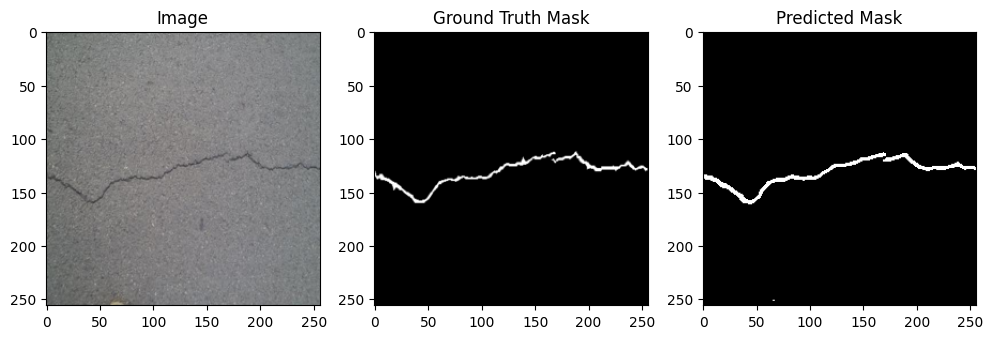

In [11]:
model.eval()
with torch.no_grad():
    img, mask = train_dataset[0]
    img = img.to(device).unsqueeze(0)

    pred = model(img)[0].cpu().numpy().squeeze()
    pred_binary = (pred > 0.5).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(train_dataset[0][0].permute(1,2,0))

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(train_dataset[0][1].squeeze(), cmap='gray')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_binary, cmap='gray')
plt.show()
